# Import Library

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Libraries for text preprocessing
import re
import nltk
nltk.download('omw-1.4')
import ssl


nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import RegexpTokenizer
nltk.download('wordnet')
from nltk.stem.wordnet import WordNetLemmatizer

from wordcloud import WordCloud

from sklearn.feature_extraction.text import CountVectorizer

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Data Preparation

In [ ]:
!kaggle datasets download -d davidwallach/financial-tweets
!unzip financial-tweets.zip

Dataset URL: https://www.kaggle.com/datasets/davidwallach/financial-tweets
License(s): DbCL-1.0
  0% 0.00/2.17M [00:00<?, ?B/s]
100% 2.17M/2.17M [00:00<00:00, 90.8MB/s]
Archive:  financial-tweets.zip
  inflating: stockerbot-export.csv   
  inflating: stocks_cleaned.csv      


In [ ]:
data = pd.read_csv('/content/stockerbot-export.csv', on_bad_lines='skip')
data

,id,text,timestamp,source,symbols,company_names,url,verified
0,1019696670777503700,VIDEO: “I was in my office. I was minding my o...,Wed Jul 18 21:33:26 +0000 2018,GoldmanSachs,GS,The Goldman Sachs,https://twitter.com/i/web/status/1019696670777...,True
1,1019709091038548000,The price of lumber $LB_F is down 22% since hi...,Wed Jul 18 22:22:47 +0000 2018,StockTwits,M,Macy's,https://twitter.com/i/web/status/1019709091038...,True
2,1019711413798035500,Who says the American Dream is dead? https://t...,Wed Jul 18 22:32:01 +0000 2018,TheStreet,AIG,American,https://buff.ly/2L3kmc4,True
3,1019716662587740200,Barry Silbert is extremely optimistic on bitco...,Wed Jul 18 22:52:52 +0000 2018,MarketWatch,BTC,Bitcoin,https://twitter.com/i/web/status/1019716662587...,True
4,1019718460287389700,How satellites avoid attacks and space junk wh...,Wed Jul 18 23:00:01 +0000 2018,Forbes,ORCL,Oracle,http://on.forbes.com/6013DqDDU,True
...,...,...,...,...,...,...,...,...
28259,1019730088617635800,$FB : 29234a9c-7f08-4d5a-985f-cb1a5554ecf9,Wed Jul 18 23:46:13 +0000 2018,test5f1798,FB,Facebook,NaN,False
28260,1019730115524288500,【仮想通貨】ビットコインの価格上昇、８０万円台回復 約１カ月半ぶり $BTC ht...,Wed Jul 18 23:46:19 +0000 2018,keizai_toushi17,BTC,Bitcoin,http://keizai-toushi-navi.com/?p=26838,False
28261,1019730115805184000,RT @invest_in_hd: 'Nuff said! $TEL #telcoin #...,Wed Jul 18 23:46:19 +0000 2018,iad81,BTC,Bitcoin,https://twitter.com/CRYPTOVERLOAD/status/10178...,False
28262,1019730117252341800,【仮想通貨】ビットコインの価格上昇、８０万円台回復 約１カ月半ぶり $BTC ht...,Wed Jul 18 23:46:20 +0000 2018,O8viWMyrCV6cBOZ,BTC,Bitcoin,http://true.velvet.jp/monexx/archives/2357,False


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28264 entries, 0 to 28263
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   id             28264 non-null  int64 
 1   text           28264 non-null  object
 2   timestamp      28264 non-null  object
 3   source         28264 non-null  object
 4   symbols        28264 non-null  object
 5   company_names  28263 non-null  object
 6   url            21895 non-null  object
 7   verified       28264 non-null  bool  
dtypes: bool(1), int64(1), object(6)
memory usage: 1.5+ MB


In [ ]:
data=data.drop(columns=['id'])

In [ ]:
data.isnull().sum()

,0
text,0
timestamp,0
source,0
symbols,0
company_names,1
url,6369
verified,0


In [ ]:
data["timestamp"] = pd.to_datetime(data["timestamp"])
data["text"] = data["text"].astype(str)
data["url"] = data["url"].astype(str)

data["company_names"] = data["company_names"].astype("category")
data["symbols"] = data["symbols"].astype("category")
data["source"] = data["source"].astype("category")
data.dtypes

<ipython-input-8-2f38deb0b3d6>:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data["timestamp"] = pd.to_datetime(data["timestamp"])


,0
text,object
timestamp,"datetime64[ns, UTC]"
source,category
symbols,category
company_names,category
url,object
verified,bool


In [ ]:
def getUniqueness():
    for columnName in data.columns:
        columnData = data[columnName]
        print(f"unique values in [{columnName}]: {columnData.nunique()}")

    print(f"total rows: {len(data.index)}")
getUniqueness()

unique values in [text]: 25685
unique values in [timestamp]: 26777
unique values in [source]: 5879
unique values in [symbols]: 453
unique values in [company_names]: 461
unique values in [url]: 17815
unique values in [verified]: 2
total rows: 28264


In [ ]:
data['date'] = data['timestamp'].dt.date
data['time'] = data['timestamp'].dt.time

data=data.drop(columns=['timestamp'])
data

,text,source,symbols,company_names,url,verified,date,time
0,VIDEO: “I was in my office. I was minding my o...,GoldmanSachs,GS,The Goldman Sachs,https://twitter.com/i/web/status/1019696670777...,True,2018-07-18,21:33:26
1,The price of lumber $LB_F is down 22% since hi...,StockTwits,M,Macy's,https://twitter.com/i/web/status/1019709091038...,True,2018-07-18,22:22:47
2,Who says the American Dream is dead? https://t...,TheStreet,AIG,American,https://buff.ly/2L3kmc4,True,2018-07-18,22:32:01
3,Barry Silbert is extremely optimistic on bitco...,MarketWatch,BTC,Bitcoin,https://twitter.com/i/web/status/1019716662587...,True,2018-07-18,22:52:52
4,How satellites avoid attacks and space junk wh...,Forbes,ORCL,Oracle,http://on.forbes.com/6013DqDDU,True,2018-07-18,23:00:01
...,...,...,...,...,...,...,...,...
28259,$FB : 29234a9c-7f08-4d5a-985f-cb1a5554ecf9,test5f1798,FB,Facebook,nan,False,2018-07-18,23:46:13
28260,【仮想通貨】ビットコインの価格上昇、８０万円台回復 約１カ月半ぶり $BTC ht...,keizai_toushi17,BTC,Bitcoin,http://keizai-toushi-navi.com/?p=26838,False,2018-07-18,23:46:19
28261,RT @invest_in_hd: 'Nuff said! $TEL #telcoin #...,iad81,BTC,Bitcoin,https://twitter.com/CRYPTOVERLOAD/status/10178...,False,2018-07-18,23:46:19
28262,【仮想通貨】ビットコインの価格上昇、８０万円台回復 約１カ月半ぶり $BTC ht...,O8viWMyrCV6cBOZ,BTC,Bitcoin,http://true.velvet.jp/monexx/archives/2357,False,2018-07-18,23:46:20


In [ ]:
data = data.dropna(subset=['company_names'])
data.isnull().sum()

,0
text,0
source,0
symbols,0
company_names,0
url,0
verified,0
date,0
time,0


In [ ]:
data.shape

(28263, 8)

# Data Visualization

## Top 10 Companies with the Most Tweets

In [ ]:
data['count'] = data.groupby('company_names')['company_names'].transform('count')
one = data[['symbols', 'company_names', 'count']].copy()


def drop_dplicated_rows(one):
    print('Before drop one shape:', one.shape)
    one.drop_duplicates(subset=['symbols', 'company_names', 'count'],
                          keep='first', inplace=True)
    one.reset_index(drop=True, inplace=True)
    print('After drop train shape:', one.shape)

drop_dplicated_rows(one)

one = one.sort_values(by=['count'], ascending=False)
one_companies_unique = one.drop_duplicates(subset=['company_names'], keep='first')
top_10_companies = one_companies_unique.head(10)
top_10_companies

Before drop one shape: (28263, 3)
After drop train shape: (464, 3)


<ipython-input-16-11dcd94d1bc3>:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  data['count'] = data.groupby('company_names')['company_names'].transform('count')
<ipython-input-16-11dcd94d1bc3>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['count'] = data.groupby('company_names')['company_names'].transform('count')


,symbols,company_names,count
221,FOX,Twenty-First Century Fox,131
455,GOOGL,Alphabet Inc.,116
128,DISCK,Discovery,102
8,NFLX,Netflix,101
425,AMAT,Applied Materials,100
370,MTB,M&T Bank Corporation,100
437,ES,Eversource Energy,100
376,MOMO,Momo Inc.,100
334,GPS,The Gap,100
296,HON,Honeywell International Inc.,100


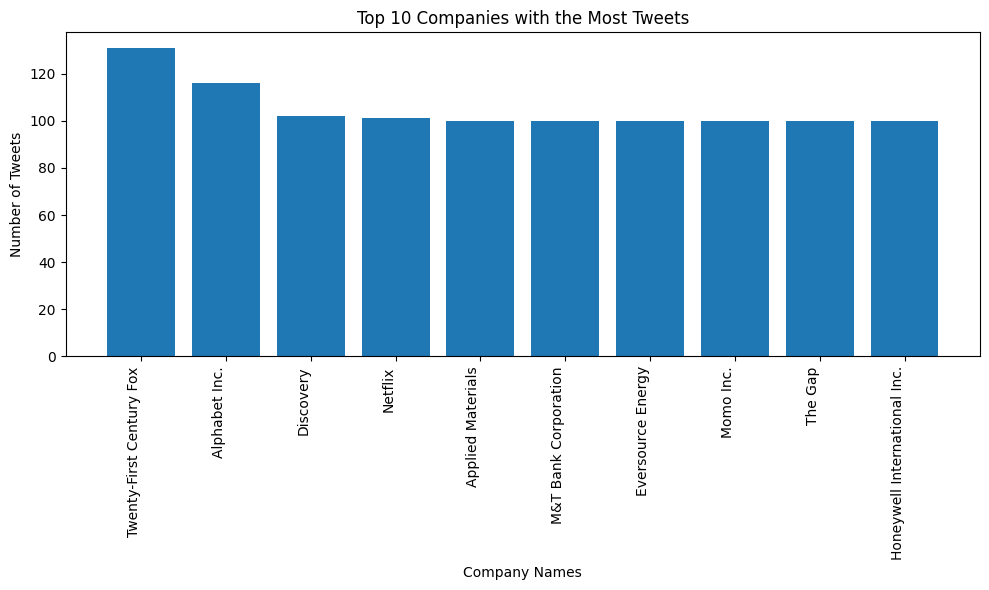

In [ ]:
plt.figure(figsize=(10, 6))
plt.bar(top_10_companies['company_names'], top_10_companies['count'])
plt.xlabel('Company Names')
plt.ylabel("Number of Tweets")
plt.title('Top 10 Companies with the Most Tweets')
plt.xticks(rotation=90, ha='right')
plt.tight_layout()
plt.show()

## Top 20 Companies with the Fewest Tweets

In [ ]:
low = one.sort_values(by=['count'], ascending=True)
low_companies_unique = low.drop_duplicates(subset=['company_names'], keep='first')
bottom_10_companies = low_companies_unique.head(20)
bottom_10_companies

,symbols,company_names,count
0,GS,The Goldman Sachs,1
9,TWX,Time Warner,1
6,HRS,Harris,1
2,AIG,American,1
5,FB-GOOGL-GOOG,Facebook*Alphabet*Alphabet,1
7,INTC-USB,Intel*U.S.,1
4,ORCL,Oracle,1
15,ticker,name,1
22,TWTR,Twitter,1
13,AMZN-GPS,Amazon*The Gap,1


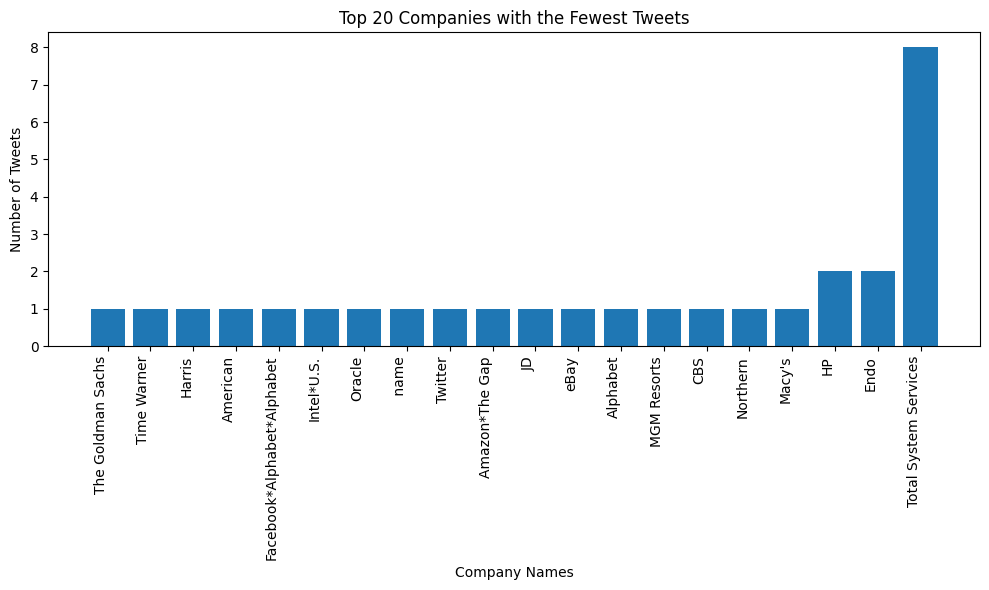

In [ ]:
plt.figure(figsize=(10, 6))
plt.bar(bottom_10_companies['company_names'], bottom_10_companies['count'])
plt.xlabel('Company Names')
plt.ylabel("Number of Tweets")
plt.title('Top 20 Companies with the Fewest Tweets')
plt.xticks(rotation=90, ha='right')
plt.tight_layout()
plt.show()

## 5 Dates with the Most Tweets

In [ ]:
date_counts = data.groupby('date')['text'].count().reset_index()
date_counts.columns = ['date', 'tweet_count']
top_5_dates = date_counts.sort_values(by=['tweet_count'], ascending=False).head(5)
top_5_dates

,date,tweet_count
11,2018-07-18,11314
10,2018-07-17,5076
9,2018-07-16,3085
8,2018-07-15,2084
5,2018-07-12,1561


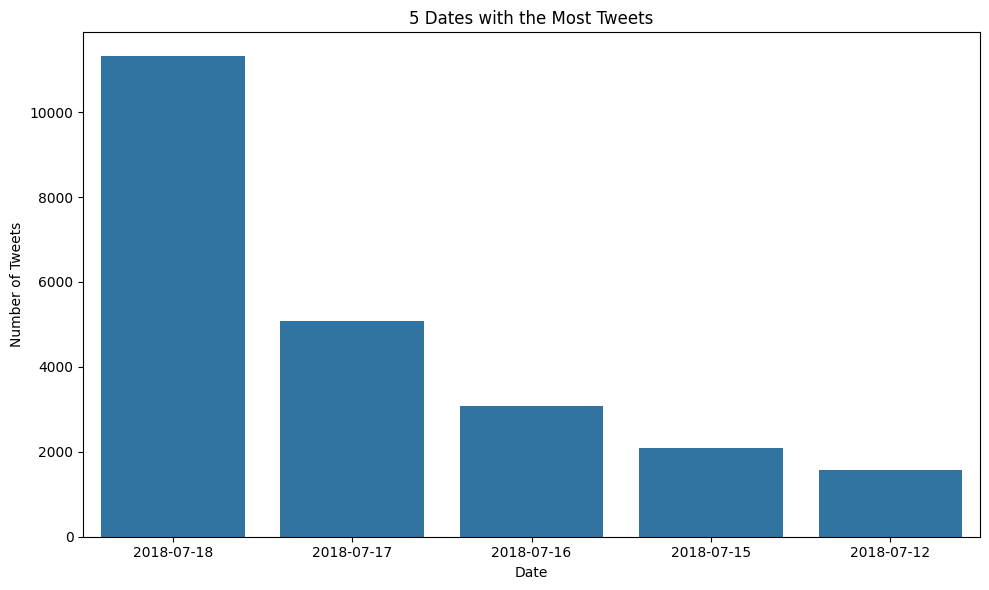

In [ ]:
plt.figure(figsize=(10, 6))
sns.barplot(x='date', y='tweet_count', data=top_5_dates)
plt.xlabel('Date')
plt.ylabel("Number of Tweets")
plt.title('5 Dates with the Most Tweets')
plt.tight_layout()
plt.show()

## 5 Dates with Few Tweets

In [ ]:
date_counts = data.groupby('date')['text'].count().reset_index()
date_counts.columns = ['date', 'tweet_count']
bottom_5_dates = date_counts.sort_values(by=['tweet_count'], ascending=True).head(3)
bottom_5_dates

,date,tweet_count
0,2018-02-23,1
12,2018-07-19,8
1,2018-07-08,20


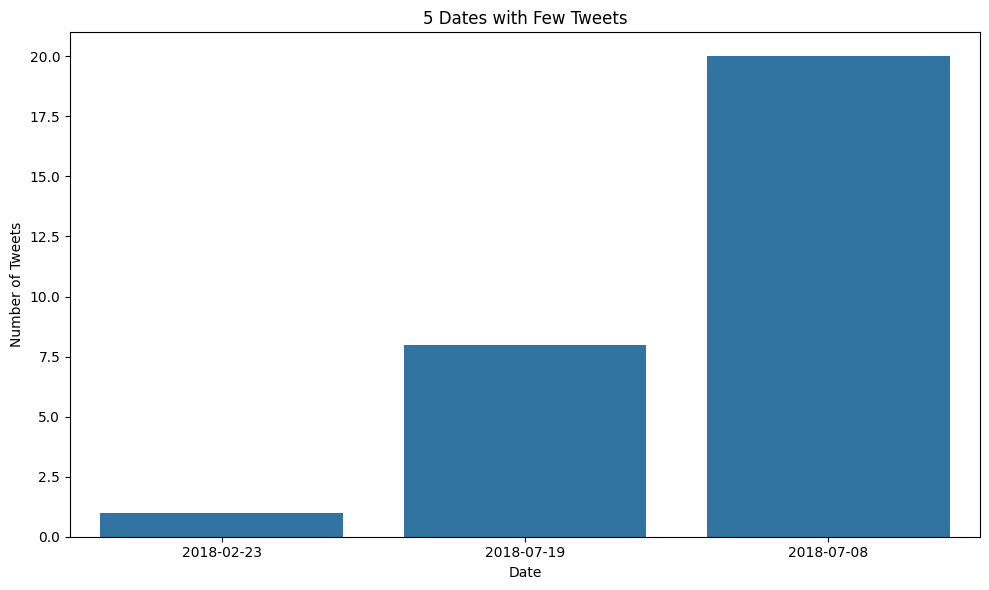

In [ ]:
plt.figure(figsize=(10, 6))
sns.barplot(x='date', y='tweet_count', data=bottom_5_dates)
plt.xlabel('Date')
plt.ylabel("Number of Tweets")
plt.title('5 Dates with Few Tweets')
plt.tight_layout()
plt.show()

## 10 Most Frequent Sources of Tweets

Text(0.5, 1.0, '10 Most Frequent Sources of Tweets')

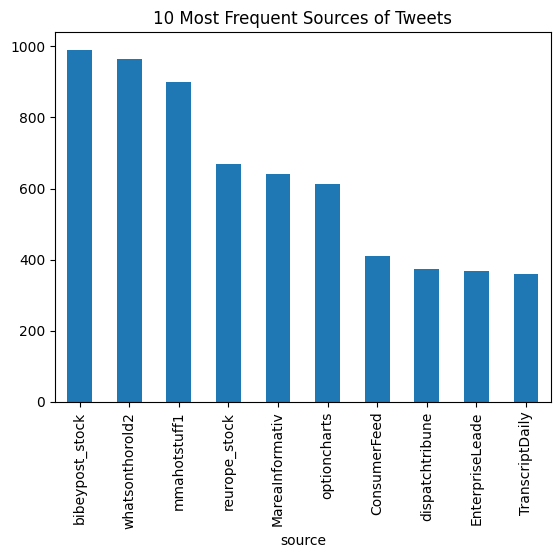

In [ ]:
total_companies = data["symbols"].value_counts()
total_sources = data["source"].value_counts()
total_sources.head(10).plot.bar()
plt.title('10 Most Frequent Sources of Tweets')

## Total Tweets on Financial Stock Market

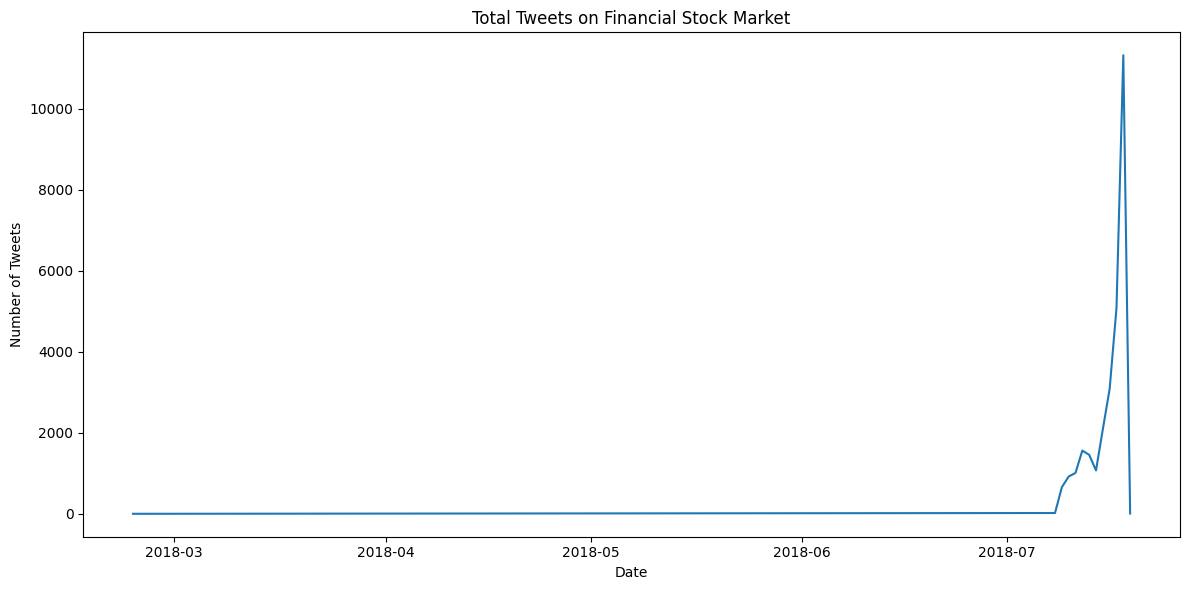

In [ ]:
date_counts = data.groupby('date')['text'].count().reset_index()
date_counts.columns = ['date', 'tweet_count']
plt.figure(figsize=(12, 6))
plt.plot(date_counts['date'], date_counts['tweet_count'])
plt.xlabel('Date')
plt.ylabel("Number of Tweets")
plt.title("Total Tweets on Financial Stock Market")
plt.tight_layout()
plt.show()

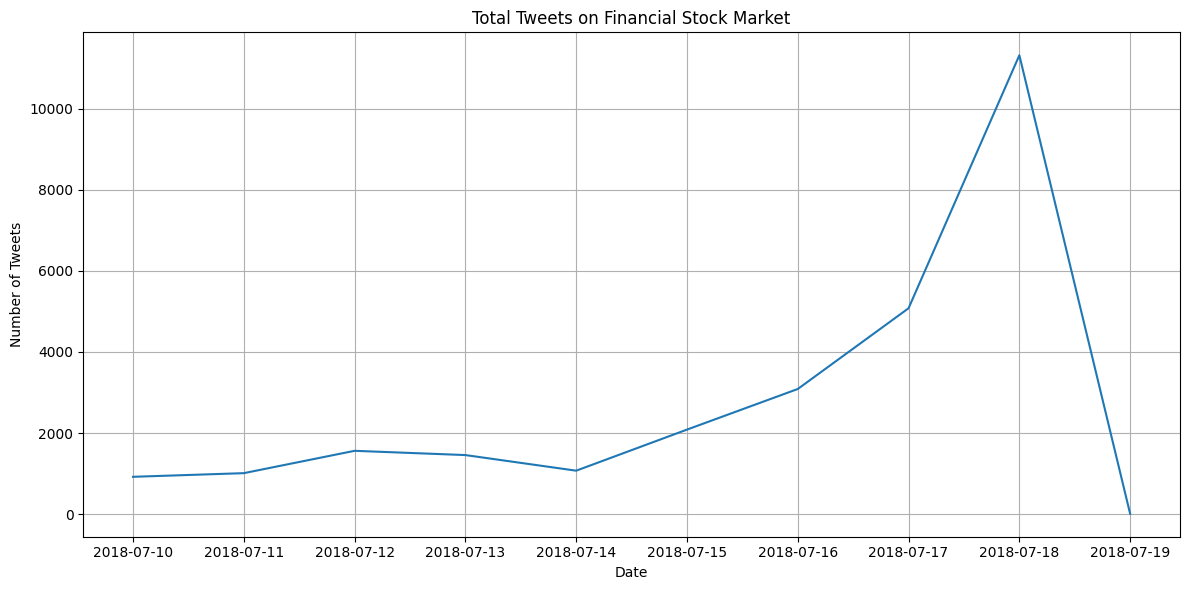

In [ ]:
start_date = '2018-07-10'

start_date = pd.to_datetime(start_date).date()
filtered_date_counts = date_counts[date_counts['date'] >= start_date]

plt.figure(figsize=(12, 6))
plt.plot(filtered_date_counts['date'], filtered_date_counts['tweet_count'])
plt.xlabel('Date')
plt.ylabel("Number of Tweets")
plt.title("Total Tweets on Financial Stock Market")
plt.grid(True)
plt.tight_layout()
plt.show()

## Top 10 Most Mentioned Companies in Financial Tweets in 2018

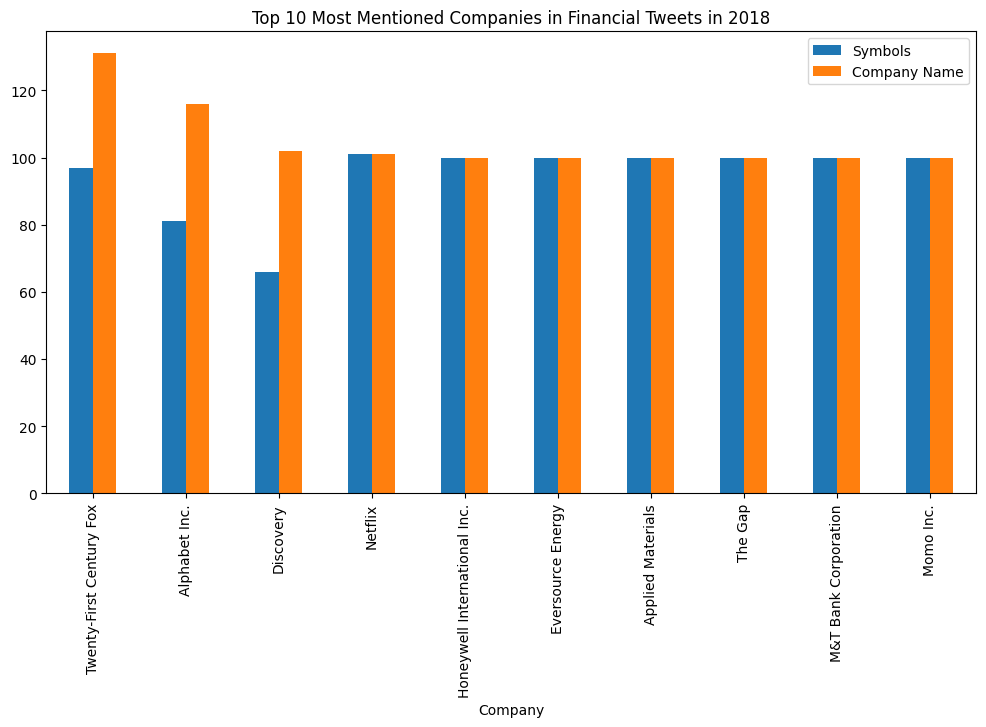

In [ ]:
unique_companies = data['company_names'].unique()

company_data = []
for company in unique_companies:
    main_symbol = data[data['company_names'] == company]['symbols'].mode()[0]
    symbol_count = data[data['symbols'] == main_symbol]['symbols'].count()
    company_name_count = data[data['company_names'] == company]['company_names'].count()
    company_data.append([company, symbol_count, company_name_count])

company_df = pd.DataFrame(company_data, columns=['Company', 'Symbols', 'Company Name'])
company_df_sorted = company_df.sort_values(by='Company Name', ascending=False)
company_data = company_df_sorted.head(10)

company_data.plot(x='Company',
                            y=['Symbols', 'Company Name'],
                            kind='bar',
                            stacked=False,
                            title='Top 10 Most Mentioned Companies in Financial Tweets in 2018',
                            figsize=(12, 6))
plt.show()

## Top 3 Most Mentioned Companies in Financial Tweets in 2018

In [ ]:
top_3_companies = data['company_names'].value_counts().nlargest(3).index.tolist()
company_symbols = {}
for company in top_3_companies:
    company_data = data[data['company_names'] == company]
    top_symbols = company_data['symbols'].value_counts().nlargest(2).index.tolist()
    company_symbols[company] = top_symbols
df = pd.DataFrame(company_symbols).T.reset_index()
df.columns = ['Company', 'Symbols 1', 'Symbols 2']
df

,Company,Symbols 1,Symbols 2
0,Twenty-First Century Fox,FOX,FOXA
1,Alphabet Inc.,GOOG,GOOGL
2,Discovery,DISCA,DISCK


In [ ]:
company_symbols = {}
for company in top_3_companies:
    company_data = data[data['company_names'] == company]
    top_symbols = company_data['symbols'].value_counts().nlargest(2).index.tolist()
    company_symbols[company] = {
        'Symbols 1': company_data['symbols'].value_counts()[top_symbols[0]] if len(top_symbols) > 0 else 0,
        'Symbols 2': company_data['symbols'].value_counts()[top_symbols[1]] if len(top_symbols) > 1 else 0
    }

df = pd.DataFrame.from_dict(company_symbols, orient='index').reset_index()
df.columns = ['Company', 'Symbols 1', 'Symbols 2']
df

,Company,Symbols 1,Symbols 2
0,Twenty-First Century Fox,97,34
1,Alphabet Inc.,81,35
2,Discovery,66,36


<Axes: title={'center': 'Top 3 Most Mentioned Companies and Symbol in Financial Tweets in 2018'}, xlabel='Company'>

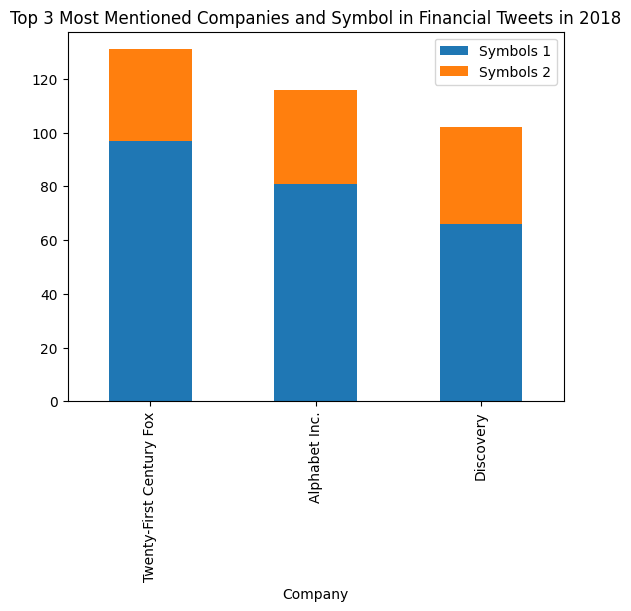

In [ ]:
df.plot(x='Company',
        kind='bar',
        stacked=True,
        title='Top 3 Most Mentioned Companies and Symbol in Financial Tweets in 2018')

## Top 10 Most Mentioned Symbol in Financial Tweets in 2018

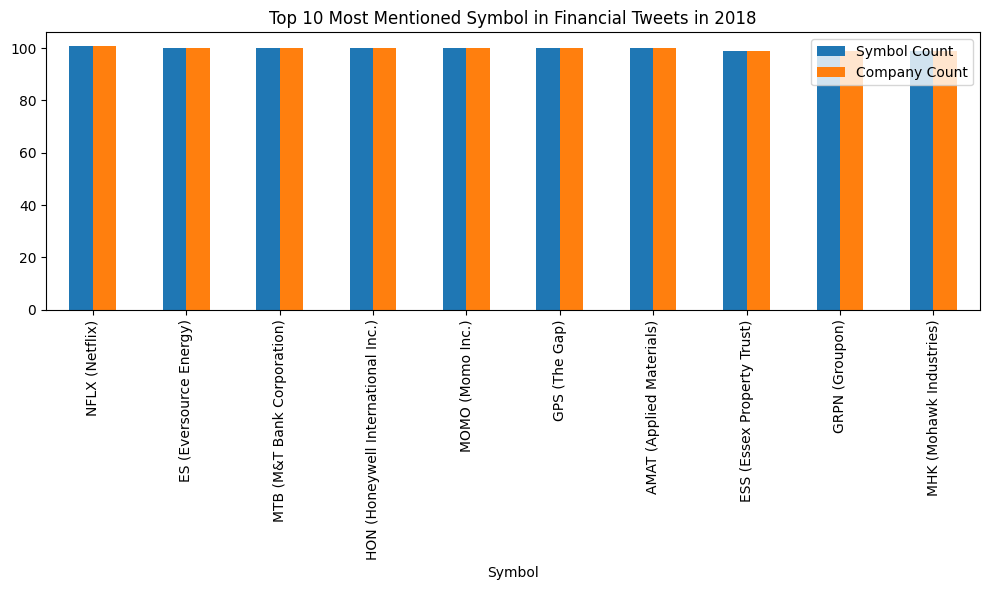

In [ ]:
top_10_symbols = data['symbols'].value_counts().nlargest(10).index.tolist()
data_list = []
for symbol in top_10_symbols:
    company = data[data['symbols'] == symbol]['company_names'].mode()[0]
    data_list.append({
        'Symbol': symbol,
        'Company': company,
        'Symbol Count': data.symbols.value_counts()[symbol],
        'Company Count': data.company_names.value_counts()[company]
    })
df = pd.DataFrame(data_list)
x_labels = [f"{symbol} ({company})" for symbol, company in zip(df['Symbol'], df['Company'])]

df.plot(x='Symbol',
        kind='bar',
        stacked=False,
        title='Top 10 Most Mentioned Symbol in Financial Tweets in 2018',
        figsize=(10, 6),
        rot=90,
        )

plt.xticks(range(len(x_labels)), x_labels)
plt.tight_layout()
plt.show()

## Top 5 Tweets from Companies with Verified and Unverified Sources

<ipython-input-52-3d928a6d51c4>:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  tweet_counts = data.groupby(['company_names', 'verified'])['text'].count().reset_index()
<ipython-input-52-3d928a6d51c4>:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  company_tweet_totals = tweet_counts.groupby('Company')['Tweet Count'].sum().sort_values(ascending=False)


<Figure size 1000x600 with 0 Axes>

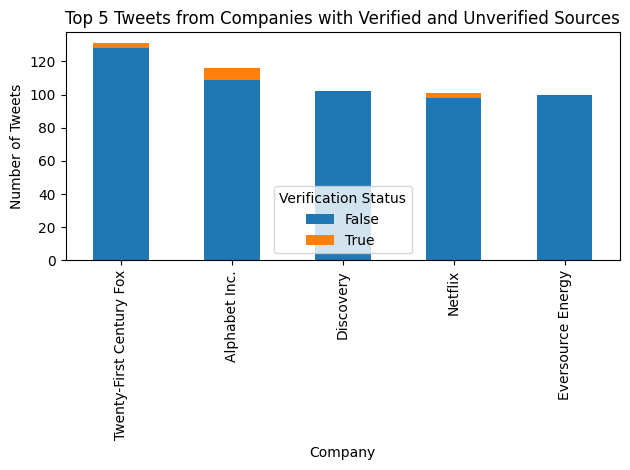

In [ ]:
tweet_counts = data.groupby(['company_names', 'verified'])['text'].count().reset_index()
tweet_counts.columns = ['Company', 'Verified', 'Tweet Count']
top_5_companies = data['company_names'].value_counts().nlargest(5).index.tolist()
tweet_counts = tweet_counts[tweet_counts['Company'].isin(top_5_companies)]

company_tweet_totals = tweet_counts.groupby('Company')['Tweet Count'].sum().sort_values(ascending=False)
top_5_companies = company_tweet_totals.index.tolist()[:5]

filtered_tweet_counts = tweet_counts[tweet_counts['Company'].isin(top_5_companies)]

plt.figure(figsize=(10, 6))
filtered_tweet_counts.pivot(index='Company', columns='Verified', values='Tweet Count').loc[top_5_companies].plot(kind='bar', stacked=True)
plt.xlabel('Company')
plt.ylabel("Number of Tweets")
plt.title('Top 5 Tweets from Companies with Verified and Unverified Sources')
plt.xticks(rotation=90)
plt.legend(title="Verification Status")
plt.tight_layout()
plt.show()

## Top 10 Most Active Tweeters by Source

<ipython-input-59-105719d3db44>:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  source_tweet_counts = data.groupby('source')['text'].count().reset_index()


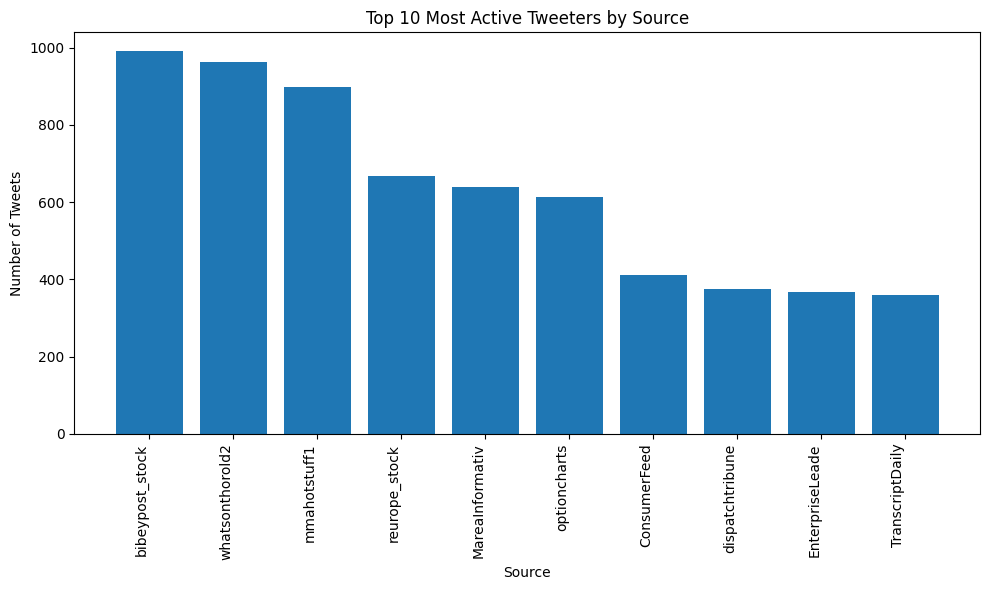

In [ ]:
source_tweet_counts = data.groupby('source')['text'].count().reset_index()
source_tweet_counts.columns = ['Source', 'Total Tweets']
top_10_sources = source_tweet_counts.sort_values(by=['Total Tweets'], ascending=False).head(10)

plt.figure(figsize=(10, 6))
plt.bar(top_10_sources['Source'], top_10_sources['Total Tweets'])
plt.xlabel('Source')
plt.ylabel('Number of Tweets')
plt.title('Top 10 Most Active Tweeters by Source')
plt.xticks(rotation=90, ha='right')
plt.tight_layout()
plt.show()

## Top 10 Most Active Verified Tweeters

<ipython-input-61-63662332fec7>:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  verified_tweet_counts = data[data['verified'] == True].groupby('source')['text'].count().reset_index()


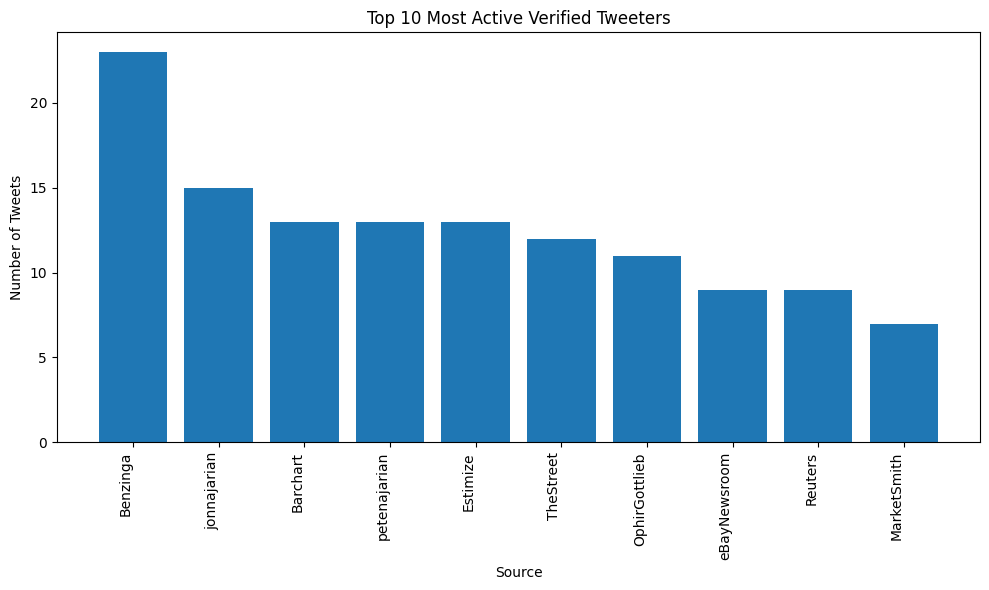

In [ ]:
verified_tweet_counts = data[data['verified'] == True].groupby('source')['text'].count().reset_index()
verified_tweet_counts.columns = ['source', 'Tweet Count']
verified_tweet_counts = verified_tweet_counts.sort_values(by=['Tweet Count'], ascending=False)
top_10_users = verified_tweet_counts.head(10)

plt.figure(figsize=(10, 6))
plt.bar(top_10_users['source'], top_10_users['Tweet Count'])
plt.xlabel('Source')
plt.ylabel('Number of Tweets')
plt.title('Top 10 Most Active Verified Tweeters')
plt.xticks(rotation=90, ha='right')
plt.tight_layout()
plt.show()

# Text Processing

In [ ]:
# Remove URLs
data.text = data.text.replace(r'http\S+', '', regex=True).replace(r'www\S+', '', regex=True)
freq = pd.Series(' '.join(data['text']).lower().split()).value_counts()[:20]
data.text

<ipython-input-63-0d06940a2910>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.text = data.text.replace(r'http\S+', '', regex=True).replace(r'www\S+', '', regex=True)


,text
0,VIDEO: “I was in my office. I was minding my o...
1,The price of lumber $LB_F is down 22% since hi...
2,Who says the American Dream is dead?
3,Barry Silbert is extremely optimistic on bitco...
4,How satellites avoid attacks and space junk wh...
...,...
28259,$FB : 29234a9c-7f08-4d5a-985f-cb1a5554ecf9
28260,【仮想通貨】ビットコインの価格上昇、８０万円台回復 約１カ月半ぶり $BTC
28261,RT @invest_in_hd: 'Nuff said! $TEL #telcoin #...
28262,【仮想通貨】ビットコインの価格上昇、８０万円台回復 約１カ月半ぶり $BTC


In [ ]:
# Stop Words
stop_words = set(stopwords.words("english"))
stop_words = stop_words.union(freq.index.tolist())
extra_words = ['amp']
stop_words = stop_words.union(extra_words)

In [ ]:
corpus = []
for i in data.index:
    #Remove punctuations
    text = re.sub('[^a-zA-Z]', ' ', data['text'][i])

    #Convert to lowercase
    text = text.lower()

    #remove tags
    text=re.sub("&lt;/?.*?&gt;"," &lt;&gt; ",text)

    # remove special characters and digits
    text=re.sub("(\\d|\\W)+"," ",text)
    text = text.replace("\n","")
    ##Convert to list from string
    text = text.split()

    ##Stemming
    ps=PorterStemmer()    #Lemmatisation
    lem = WordNetLemmatizer()
    text = [lem.lemmatize(word) for word in text if not word in
            stop_words]
    data['keywords'] = pd.Series(text)
    text = " ".join(text)
    corpus.append(text)

<ipython-input-67-420ff6cfde9b>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['keywords'] = pd.Series(text)


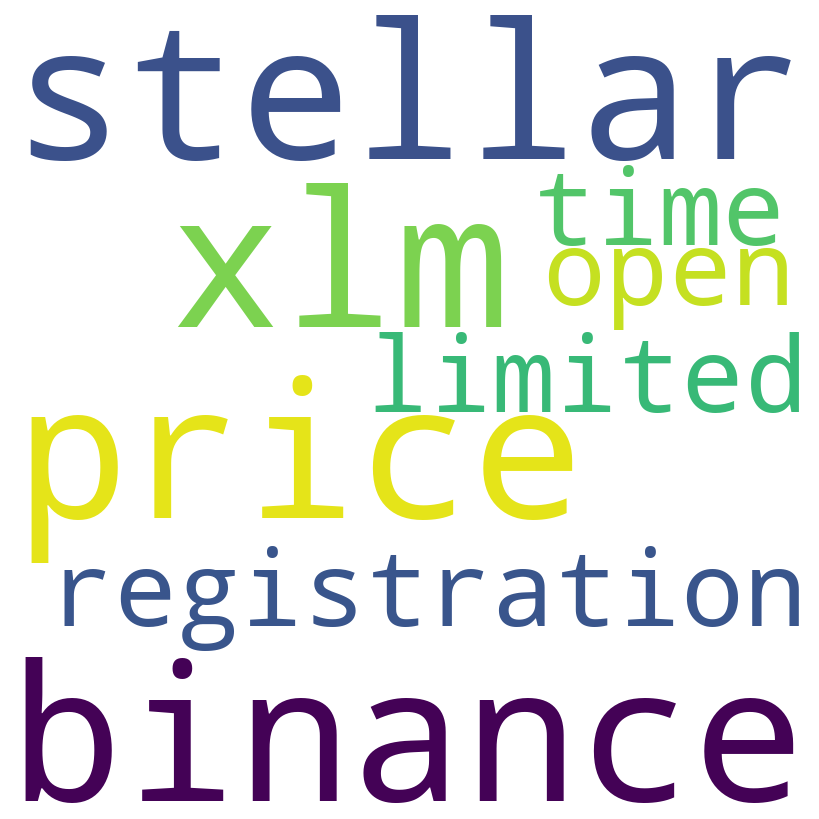

In [ ]:
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stop_words,
                min_font_size = 10).generate(text)

plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)

plt.show()

In [ ]:
cv=CountVectorizer(max_df=0.8,stop_words=list(stop_words), max_features=10000, ngram_range=(1,3))
X=cv.fit_transform(corpus)

<ipython-input-75-55704ae80aec>:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g.set_xticklabels(g.get_xticklabels(), rotation=30)


Text(0.5, 1.0, 'Most Frequently Appearing Words in Tweets')

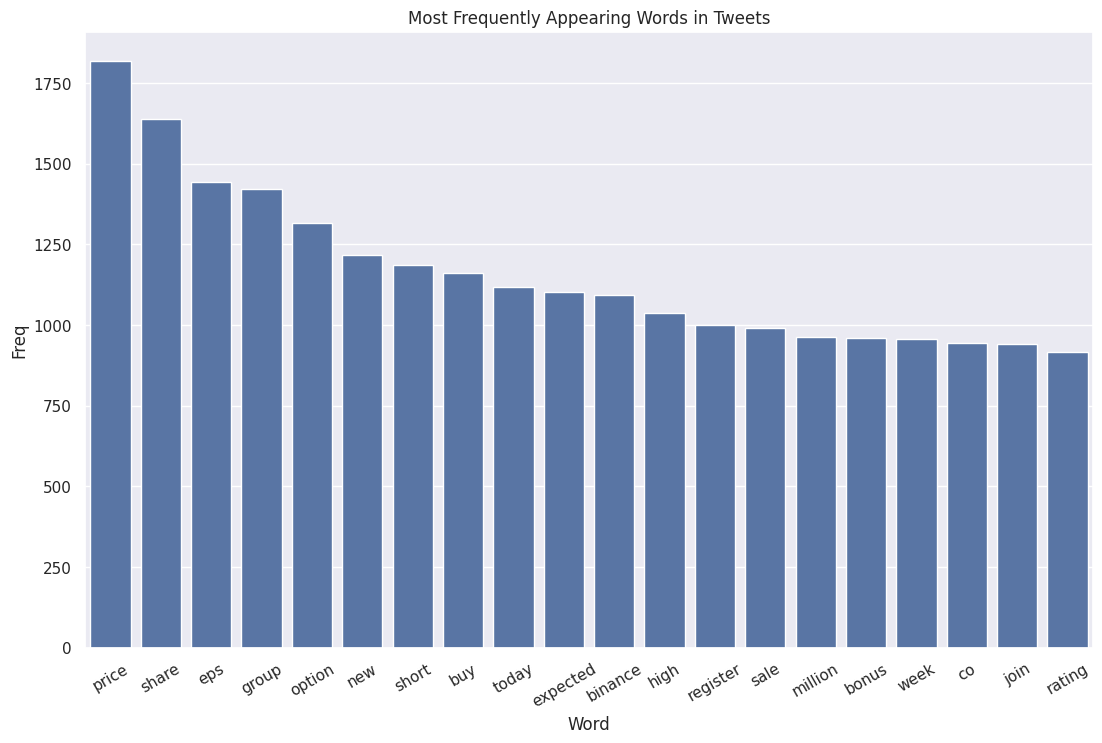

In [ ]:
def get_top_n_words(corpus, n=None):
    bag_of_words = cv.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = []
    for word, idx in cv.vocabulary_.items():
        if  len(word.split()) ==1:
            words_freq.append((word, sum_words[0, idx]))
    words_freq =sorted(words_freq, key = lambda x: x[1],
                       reverse=True)
    return words_freq[:n]
top_words = get_top_n_words(corpus, n=20)
top_df = pd.DataFrame(top_words)
top_df.columns=["Word", "Freq"]

sns.set(rc={'figure.figsize':(13,8)})
g = sns.barplot(x="Word", y="Freq", data=top_df)
g.set_xticklabels(g.get_xticklabels(), rotation=30)
plt.title("Most Frequently Appearing Words in Tweets")